In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np

torch.manual_seed(8)

## MLP

In [2]:
class Dropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(Dropout, self).__init__()
        self.dropout_rate = dropout_rate
        # define the scaling factor to remaining nodes to compensate for dropped nodes
        if self.dropout_rate < 1:
            self.scaling_fct = 1.0 / (1.0-dropout_rate)
        else:
            self.scaling_fct = 0.0

    def forward(self, input):
        # only apply dropout during training mode
        if not self.training:
            return input
        # indicator tensor of same size to label the selected nodes
        selected_ind = torch.Tensor(input.shape).uniform_(0,1) > self.dropout_rate
        # use GPU if available
        if input.is_cuda:
            selected_ind = Variable(selected_ind.type(torch.cuda.FloatTensor), requires_grad=False)
        else:
            selected_ind = Variable(selected_ind.type(torch.FloatTensor), requires_grad=False)
        # drop out some nodes and scale up the rest
        return torch.mul(selected_ind, input) * self.scaling_fct

4

In [3]:
class MLP(nn.Module):
    def __init__(self, hidden_layers=[800, 800], dropout_rates=[0, 0]):
        super(MLP, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module("input", nn.Linear(28*28, hidden_layers[0]))
        self.model.add_module("dropout_input", Dropout(dropout_rate=dropout_rates[0]))
        self.model.add_module("tanh", nn.Tanh())
        # add hidden layers
        for i,d in enumerate(hidden_layers[:-1]):
            self.model.add_module("dropout_hidden_"+str(i+1), Dropout(dropout_rate=dropout_rates[1]))
            self.model.add_module("hidden_"+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            self.model.add_module("tanh_hidden_"+str(i+1), nn.Tanh())
        self.model.add_module("final",nn.Linear(hidden_layers[-1], 10))        
        
    def forward(self, x):
        # flatten to one-dimensional array
        x = x.view(x.shape[0], 28*28)
        x = self.model(x)
        return x

In [28]:
model = MLP()
print(model)

MLP(
  (model): Sequential(
    (input): Linear(in_features=784, out_features=800, bias=True)
    (dropout_input): Dropout()
    (tanh): Tanh()
    (dropout_hidden_1): Dropout()
    (hidden_1): Linear(in_features=800, out_features=800, bias=True)
    (tanh_hidden_1): Tanh()
    (final): Linear(in_features=800, out_features=10, bias=True)
  )
)


In [4]:
class MLPClassifier:
    def __init__(self, hidden_layers=[800, 800], dropout_rates=[0, 0], batch_size=128, \
                 max_epoch=10, lr=0.1):
        # save and initiate utility variables
        self.hidden_layers = hidden_layers
        self.dropout_rates = dropout_rates
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.model = MLP(hidden_layers=hidden_layers, dropout_rates=dropout_rates)
        self.model.cuda()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.loss = []
        self.test_accuracy = []
        
    def fit(self, trainset, testset, verbose=True, test_score_freq=5):
        # prepare training and test sets
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
        X_test, y_test = iter(testloader).next()
        X_test = X_test.cuda()
        # start training procedure, best run on GPU
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, training_batch in enumerate(trainloader, 0):
                X_train, y_train = training_batch
                # send to GPU if available
                X_train, y_train = Variable(X_train).cuda(), Variable(y_train).cuda()
                # clear gradients
                self.optimizer.zero_grad()
                # make prediction
                y_pred = self.model(X_train)
                # calculate loss of current batch
                loss = self.criterion(y_pred, y_train)
                # perform back propagation to calculate gradients automatically
                loss.backward()
                # update weights
                self.optimizer.step()
                # add loss of different batches within the same epoch
                running_loss += loss.item()
            # store average loss per batch for all epochs
            self.loss.append(running_loss / len(trainloader))
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, self.loss[-1]))
            if (epoch+1) % test_score_freq == 0:
                # get predictions for the test set
                y_test_pred = self.predict(X_test).cpu()
                self.y_test_pred = y_test_pred
                self.y_test = y_test
                # store test set accuracy
                self.test_accuracy.append(np.mean((y_test == y_test_pred).numpy()))
                if verbose:
                    print('Test accuracy: {}'.format(self.test_accuracy[-1]))
        return self
    
    # make class predictions for test set
    def predict(self, x):
        model = self.model.eval()
        outputs = model(Variable(x))
        _, pred = torch.max(outputs.data, 1)
        model = self.model.train()
        return pred

In [ ]:
# load and transform MNIST
transform = transforms.Compose([transforms.ToTensor(), \
                                transforms.Normalize([0.5], [0.5])])
trainset = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='data/', train=False, transform=transform)
# define three FCN models
hidden_layers = [300, 300]
model_list = [MLPClassifier(hidden_layers, dropout_rates=[0, 0], max_epoch=500), 
        MLPClassifier(hidden_layers, dropout_rates=[0, 0.5], max_epoch=500),
        MLPClassifier(hidden_layers, dropout_rates=[0.2, 0.5], max_epoch=500)]
# start training
[tmp_model.fit(trainset, testset,verbose=True) for tmp_model in model_list]
# save torch models
for ind, tmp_model in enumerate(model_list):
    torch.save(tmp_model.model, 'mnist_mlp_'+str(ind)+'.pth')
    tmp_model.test_accuracy = list(map(str, tmp_model.test_accuracy))
# save test accuracy
from google.colab import files
open("mlp_test_accuracy.txt","w").write('\n'.join([','.join(tmp_mlp.test_accuracy) for tmp_mlp in model_list]))
files.download('mlp_test_accuracy.txt')

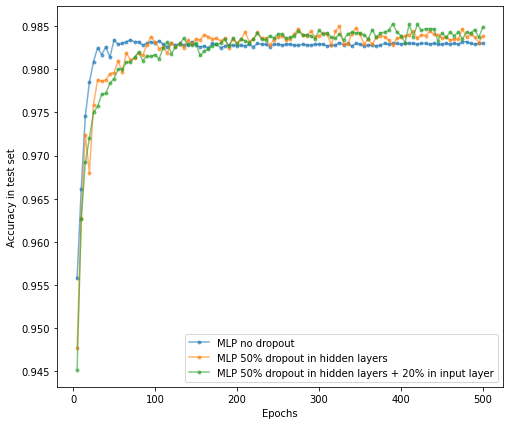

In [20]:
import matplotlib.pyplot as plt

# Load saved test errors to plot figures.
mlp_test_accuracy = [accuracy_array.split(',') for accuracy_array in open("mlp_test_accuracy.txt","r").read().split('\n')]
mlp_test_accuracy = np.array(mlp_test_accuracy, dtype='f')

labels = ['MLP no dropout', 
          'MLP 50% dropout in hidden layers', 
          'MLP 50% dropout in hidden layers + 20% in input layer']

plt.figure(figsize=(8, 7))
for i, r in enumerate(mlp_test_accuracy):
    plt.plot(np.array(range(1, len(r)+1))*5, r, '.-', label=labels[i], alpha=0.6);
plt.legend(loc=4);
plt.xlabel('Epochs');
plt.ylabel('Accuracy in test set');
plt.show()

## LeNet

In [2]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

class LeNet(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(LeNet, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module('conv1', nn.Conv2d(1, 20, kernel_size=5, padding=2))
        self.model.add_module('dropout1', nn.Dropout2d(p=dropout_rate))
        self.model.add_module('maxpool1', nn.MaxPool2d(2, stride=2))
        self.model.add_module('conv2', nn.Conv2d(20, 50, kernel_size=5, padding=2))
        self.model.add_module('dropout2', nn.Dropout2d(p=dropout_rate))
        self.model.add_module('maxpool2', nn.MaxPool2d(2, stride=2))
        self.model.add_module('flatten', Flatten())
        self.model.add_module('dense3', nn.Linear(50*7*7, 500))
        self.model.add_module('relu3', nn.ReLU())
        self.model.add_module('dropout3', nn.Dropout(p=dropout_rate))
        self.model.add_module('final', nn.Linear(500, 10))
        
    def forward(self, x):
        return self.model(x)

In [3]:
model = LeNet()
print(model)

LeNet(
  (model): Sequential(
    (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (dropout1): Dropout2d(p=0.5, inplace=False)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (dropout2): Dropout2d(p=0.5, inplace=False)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten()
    (dense3): Linear(in_features=2450, out_features=500, bias=True)
    (relu3): ReLU()
    (dropout3): Dropout(p=0.5, inplace=False)
    (final): Linear(in_features=500, out_features=10, bias=True)
  )
)


In [4]:
class LeNetClassifier:
    def __init__(self, dropout_rate=0.5, batch_size=128, max_epoch=300, lr=0.01):
        # save and initiate utility variables
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.lr = lr
        self.model = LeNet(dropout_rate)
        self.model.cuda()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.loss = []
        self.test_accuracy = []
        
    def fit(self, trainset, testset, verbose=True, test_score_freq=5):
        # prepare training and test sets
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
        X_test, y_test = iter(testloader).next()
        X_test = X_test.cuda()
        # start training procedure, best run on GPU
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, training_batch in enumerate(trainloader, 0):
                X_train, y_train = training_batch
                # send to GPU if available
                X_train, y_train = Variable(X_train).cuda(), Variable(y_train).cuda()
                # clear gradients
                self.optimizer.zero_grad()
                # make prediction
                y_pred = self.model(X_train)
                # calculate loss of current batch
                loss = self.criterion(y_pred, y_train)
                # perform back propagation to calculate gradients automatically
                loss.backward()
                # update weights
                self.optimizer.step()
                # add loss of different batches within the same epoch
                running_loss += loss.item()
            # store average loss per batch for all epochs
            self.loss.append(running_loss / len(trainloader))
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, self.loss[-1]))
            if (epoch+1) % test_score_freq == 0:
                # get predictions for the test set
                y_test_pred = self.predict(X_test).cpu()
                self.y_test_pred = y_test_pred
                self.y_test = y_test
                # store test set accuracy
                self.test_accuracy.append(np.mean((y_test == y_test_pred).numpy()))
                if verbose:
                    print('Test accuracy: {}'.format(self.test_accuracy[-1]))
        return self
    
    # make class predictions for test set
    def predict(self, x):
        model = self.model.eval()
        outputs = model(Variable(x))
        _, pred = torch.max(outputs.data, 1)
        model = self.model.train()
        return pred

In [5]:
# load MNIST
transform = transforms.Compose([transforms.ToTensor(), \
                                transforms.Normalize([0.5], [0.5])])

trainset = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='data/', train=False, transform=transform)

# Define networks
lenet_list = [LeNetClassifier(dropout_rate=0, max_epoch=500),
          LeNetClassifier(dropout_rate=0.5, max_epoch=500)]
        
# start training
[lenet.fit(trainset, testset,verbose=True) for lenet in lenet_list]

# Save torch models
for ind, lenet in enumerate(lenet_list):
    torch.save(lenet.model, 'mnist_lenet_'+str(ind)+'.pth')
    # Prepare to save errors
    lenet.test_accuracy = list(map(str, lenet.test_accuracy))

# Save test accuracy to plot figures
from google.colab import files
open("lenet_test_accuracy.txt","w").write('\n'.join([','.join(lenet.test_accuracy) for lenet in lenet_list])) 
files.download('lenet_test_accuracy.txt')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Epoch 1 loss: 0.8734755944659207
Epoch 2 loss: 0.25499455889722683
Epoch 3 loss: 0.17691441645214298
Epoch 4 loss: 0.13335478362212302
Epoch 5 loss: 0.1074233212267984
Test accuracy: 0.9719
Epoch 6 loss: 0.09015832378713688
Epoch 7 loss: 0.07769234400830352
Epoch 8 loss: 0.06894374141560942
Epoch 9 loss: 0.06194850289896289
Epoch 10 loss: 0.056854922630226436
Test accuracy: 0.9833
Epoch 11 loss: 0.052070346436520885
Epoch 12 loss: 0.048230401526239
Epoch 13 loss: 0.044735696005907016
Epoch 14 loss: 0.04155575814368978
Epoch 15 loss: 0.03947590064031006
Test accuracy: 0.9853
Epoch 16 loss: 0.03734043417925408
Epoch 17 loss: 0.03513472151062858
Epoch 18 loss: 0.032754330455498304
Epoch 19 loss: 0.031057928516062847
Epoch 20 loss: 0.02994254684554282
Test accuracy: 0.9876
Epoch 21 loss: 0.028243451235768224
Epoch 22 loss: 0.026917095030985598
Epoch 23 loss: 0.025541069304773102
Epoch 24 loss: 0.024463233457548597
Epoch

1373

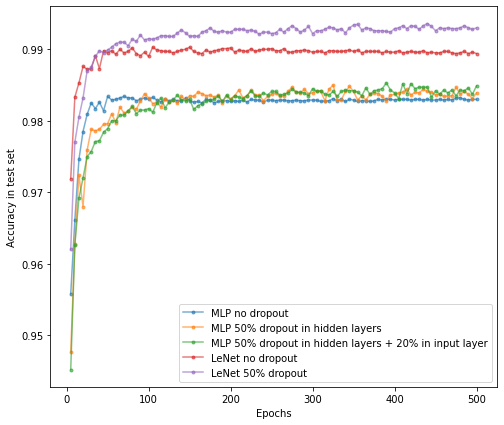

In [10]:
import matplotlib.pyplot as plt

mlp_test_accuracy = [accuracy_array.split(',') for accuracy_array in open("mlp_test_accuracy.txt","r").read().split('\n')]
mlp_test_accuracy = np.array(mlp_test_accuracy, dtype='f')
lenet_test_accuracy = [accuracy_array.split(',') for accuracy_array in open("lenet_test_accuracy.txt","r").read().split('\n')]
lenet_test_accuracy = np.array(lenet_test_accuracy, dtype='f')

labels = ['MLP no dropout', 
          'MLP 50% dropout in hidden layers', 
          'MLP 50% dropout in hidden layers + 20% in input layer',
          'LeNet no dropout',
          'LeNet 50% dropout']

plt.figure(figsize=(8, 7))
for i, r in enumerate(mlp_test_accuracy.tolist() + lenet_test_accuracy.tolist()):
    plt.plot(np.array(range(1, len(r)+1))*5, r, '.-', label=labels[i], alpha=0.6);
plt.legend(loc=4);
plt.xlabel('Epochs');
plt.ylabel('Accuracy in test set');
plt.show()